<a href="https://colab.research.google.com/github/priyadarshi2022-max/Quantaucs.ai_Assignment/blob/main/notebooks/quantaucs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helper Functions

In [ ]:
def missing_info(data):
  na_cols = [col for col in data.columns if data[col].isna().any()]
  na_counts = [data[col].isna().sum() for col in na_cols]
  na_pct = [(data[col].isna().mean()*100) for col in na_cols]

  return (
      pd
      .DataFrame(data={
          "variable": na_cols,
          "count": na_counts,
          "percentage": na_pct
      })
      .sort_values(by="count", ascending=False)
      .set_index("variable")
  )

# Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from minisom import MiniSom
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score
import joblib

In [ ]:
!pip install MiniSom -q

  Preparing metadata (setup.py) ... done


# Datasets Description

In [ ]:
email_df = pd.read_csv("/content/email_table.csv")
opened_df = pd.read_csv("/content/email_opened_table.csv")
clicked_df = pd.read_csv("/content/link_clicked_table.csv")

In [ ]:
email_df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [ ]:
email_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


* The provided dataset `email_df` has 7 columns and 100,000 rows. The majority of the column is made up of categorical information. There are no null-values in this dataframe.
* Description of all the columns:
1. **email_id** : the Id of the email that was sent. It is unique by email.
2. **email_text** : there are two versions of the email: one has “long text” (i.e. has 4 paragraphs) and one has “short text” (just two paragraphs)
3. **email_version** : some emails were “personalized” (i.e. they had the name of the user receiving the email in the incipit, such as “Hi John”), while some emails were “generic” (the incipit was just “Hi,”).
4. **hour** : the local time on which the email was sent.
weekday : the day on which the email was sent.
5. **user_country** : the country where the user receiving the email was based. It comes from the user ip address when she created the account.
6. **user_past_purchases** : how many items in the past were bought by the user receiving the email

In [ ]:
opened_df.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [ ]:
opened_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  10345 non-null  int64
dtypes: int64(1)
memory usage: 80.9 KB


* `opened_df` has single column and it shows the id of the emails that were opened, i.e. the user clicked on the email, and supposedly, read it.

In [ ]:
clicked_df.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [ ]:
clicked_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  2119 non-null   int64
dtypes: int64(1)
memory usage: 16.7 KB


* `clicked_df` has also single column and it shows the id of the emails whose link inside was clicked at least once.

# Preprocessing & Feature Engineering

* We created one extra column for both `opened_df` and `clicked_df` and the column will include which will show that it has opened and clicked respectively.

In [ ]:
opened_df['opened'] = 1
clicked_df['clicked'] = 1

In [ ]:
opened_df.head()

,email_id,opened
0,284534,1
1,609056,1
2,220820,1
3,905936,1
4,164034,1


In [ ]:
clicked_df.head()

,email_id,clicked
0,609056,1
1,870980,1
2,935124,1
3,158501,1
4,177561,1


## Merging the three tables

In [ ]:
# merging opened info
merged_df = pd.merge(email_df, opened_df, on='email_id', how='left')

# merging clicked info
merged_df = pd.merge(merged_df, clicked_df, on='email_id', how='left')

In [ ]:
merged_df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,NaN,NaN
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,NaN,NaN
3,493711,short_email,generic,6,Monday,UK,1,NaN,NaN
4,106887,long_email,generic,14,Monday,US,6,NaN,NaN


* If an email wasn't opened or clicked, the flags will be NaN. So we need to convert it to 0

In [ ]:
merged_df['opened'] = merged_df['opened'].fillna(0).astype(int)
merged_df['clicked'] = merged_df['clicked'].fillna(0).astype(int)

In [ ]:
merged_df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


In [ ]:
merged_df.duplicated().sum()

np.int64(0)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
 7   opened               100000 non-null  int64 
 8   clicked              100000 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 6.9+ MB


* Checking for ambigous values in categorical features

In [ ]:
# count the number of unique values in email_text column
merged_df['email_text'].nunique()

2

In [ ]:
merged_df.email_text.value_counts()

,count
email_text,
long_email,50276
short_email,49724


In [ ]:
# count the number of unique values in email_version column
merged_df['email_version'].nunique()

2

In [ ]:
merged_df.email_version.value_counts()

,count
email_version,
generic,50209
personalized,49791


In [ ]:
merged_df.weekday.value_counts()

,count
weekday,
Saturday,14569
Sunday,14387
Monday,14363
Thursday,14277
Friday,14177
Tuesday,14143
Wednesday,14084


In [ ]:
merged_df.user_country.value_counts()

,count
user_country,
US,60099
UK,19939
FR,9995
ES,9967


* To ensure the original dataset remains unchanged, we will create a copy of the `merged_df`

In [ ]:
df = merged_df.copy()

## Encoding categorical variables

In [ ]:
df_encoded = pd.get_dummies(df, columns=['email_text', 'email_version', 'weekday', 'user_country'], drop_first=True)

In [ ]:
df_encoded.head()

,email_id,hour,user_past_purchases,opened,clicked,email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US
0,85120,2,5,0,0,True,True,False,False,True,False,False,False,False,False,True
1,966622,12,2,1,1,False,True,False,False,True,False,False,False,False,True,False
2,777221,11,2,0,0,False,True,False,False,False,False,False,True,False,False,True
3,493711,6,1,0,0,True,False,True,False,False,False,False,False,False,True,False
4,106887,14,6,0,0,False,False,True,False,False,False,False,False,False,False,True


## Define features and target

In [ ]:
X = df_encoded.drop(columns=['email_id', 'clicked'])
y = df_encoded['clicked']

## Split into Train (70%), Validation (15%), Test (15%)

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.17647, random_state=42, stratify=y_temp)

# Training through LightGBM Model and Evaluation

In [ ]:
# 5. Setup LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# 6. 10-Fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(lgb_model, X_train, y_train, cv=cv, scoring='roc_auc')

print("\n\n10-Fold CV ROC-AUC Scores:", cv_scores)
print("\nMean CV ROC-AUC Score:", np.mean(cv_scores))

[LightGBM] [Info] Number of positive: 1335, number of negative: 61665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 63000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021190 -> initscore=-3.832785
[LightGBM] [Info] Start training from score -3.832785
[LightGBM] [Info] Number of positive: 1335, number of negative: 61665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 63000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021190 -> initscore=-3.832785
[LightGBM] [Info] Start training from score -3.832785
[LightGBM] [Info] 

In [ ]:
# 7. Fit on training data and validate on validation set
lgb_model.fit(X_train, y_train)
val_preds = lgb_model.predict(X_val)
val_probs = lgb_model.predict_proba(X_val)[:, 1]

print("Validation Classification Report:")
print(classification_report(y_val, val_preds))
print("Validation ROC-AUC Score:", roc_auc_score(y_val, val_probs))

[LightGBM] [Info] Number of positive: 1483, number of negative: 68517
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021186 -> initscore=-3.833015
[LightGBM] [Info] Start training from score -3.833015
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     14682
           1       0.43      0.07      0.12       318

    accuracy                           0.98     15000
   macro avg       0.71      0.53      0.55     15000
weighted avg       0.97      0.98      0.97     15000

Validation ROC-AUC Score: 0.9570571161024624


In [ ]:
# 8. Final Evaluation on Test Set
test_preds = lgb_model.predict(X_test)
test_probs = lgb_model.predict_proba(X_test)[:, 1]

print("Test Classification Report:")
print(classification_report(y_test, test_preds))
print("Test ROC-AUC Score:", roc_auc_score(y_test, test_probs))

# 9. Save model
joblib.dump(lgb_model, 'final_lgb_model.pkl')

Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     14682
           1       0.37      0.04      0.08       318

    accuracy                           0.98     15000
   macro avg       0.67      0.52      0.53     15000
weighted avg       0.97      0.98      0.97     15000

Test ROC-AUC Score: 0.9604526871135579


['final_lgb_model.pkl']

# Encoding to SMOTE + Class Weights + Cross-Validation + Evaluation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

# -------------------- 1. Encoding and Splitting --------------------
df = merged_df.copy()
df_encoded = pd.get_dummies(df, columns=['email_text', 'email_version', 'weekday', 'user_country'], drop_first=True)

X = df_encoded.drop(columns=['email_id', 'clicked'])
y = df_encoded['clicked']

# Train-Test Split (70-15-15)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.17647, random_state=42, stratify=y_temp)
# 0.17647 ≈ 15% of original → (0.17647 * 0.85 ≈ 0.15)


In [ ]:
# -------------------- 2. Class Weights --------------------
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}

In [ ]:
# -------------------- 3. SMOTE Oversampling --------------------
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# -------------------- 4. LightGBM Model --------------------
lgb_model = LGBMClassifier(
    class_weight=class_weights,
    random_state=42,
    n_jobs=-1,
    n_estimators=1000,
    learning_rate=0.05
)

In [ ]:
# -------------------- 5. 10-Fold Cross-Validation --------------------
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(lgb_model, X_train_resampled, y_train_resampled, cv=cv, scoring='roc_auc')

print("10-Fold CV ROC-AUC Scores:", cv_scores)
print("Mean CV ROC-AUC Score:", np.mean(cv_scores))

[LightGBM] [Info] Number of positive: 61665, number of negative: 61665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 123330, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.978814 -> initscore=3.833015
[LightGBM] [Info] Start training from score 3.833015
[LightGBM] [Info] Number of positive: 61665, number of negative: 61665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 123330, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.978814 -> initscore=3.833015
[LightGBM] [Info] Start training from score 3.833015
[LightGBM] [Info] 

In [ ]:
# -------------------- 6. Final Training & Evaluation --------------------
lgb_model.fit(X_train_resampled, y_train_resampled)

# --- Validation Set ---
y_val_pred = lgb_model.predict(X_val)
y_val_pred_proba = lgb_model.predict_proba(X_val)[:, 1]

print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Validation ROC-AUC Score:", roc_auc_score(y_val, y_val_pred_proba))

# --- Test Set ---
y_test_pred = lgb_model.predict(X_test)
y_test_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test ROC-AUC Score:", roc_auc_score(y_test, y_test_pred_proba))

[LightGBM] [Info] Number of positive: 68517, number of negative: 68517
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 137034, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.978814 -> initscore=3.833015
[LightGBM] [Info] Start training from score 3.833015

Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.95     14682
           1       0.18      0.81      0.29       318

    accuracy                           0.92     15000
   macro avg       0.59      0.87      0.62     15000
weighted avg       0.98      0.92      0.94     15000

Validation ROC-AUC Score: 0.9348569120276486

Test Classification Report:
              precision    recall  f1-score   support

           0      

# Tuning Precision vs Recall

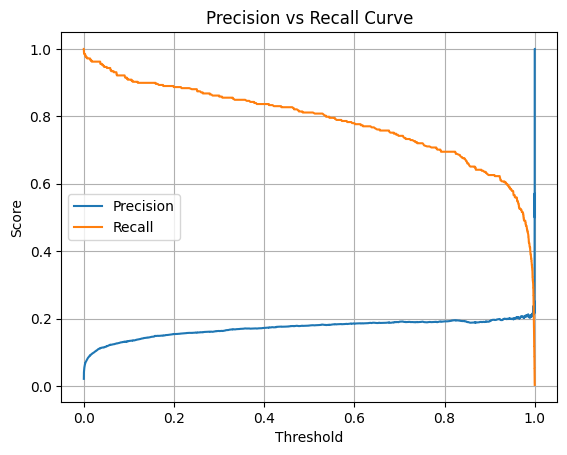

In [ ]:
from sklearn.metrics import precision_recall_curve

probs = lgb_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# Plot precision-recall curve to find sweet spot
import matplotlib.pyplot as plt
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.title('Precision vs Recall Curve')
plt.show()

In [ ]:
# Example: threshold = 0.3 instead of default 0.5
y_pred_thresh = (probs > 0.3).astype(int)
print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     14682
           1       0.16      0.86      0.27       318

    accuracy                           0.90     15000
   macro avg       0.58      0.88      0.61     15000
weighted avg       0.98      0.90      0.93     15000

